In [1]:
#The variables which are commented are to use the CPU instead of the GPU
#The os variable set in -1 will disable the GPU

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


#The threads variables are used to set the number of threads to be used when CPU test are needed

# Number of threads
#os.environ['TF_NUM_INTEROP_THREADS'] = '32'
#os.environ['TF_NUM_INTRAOP_THREADS'] = '32'

2023-08-08 16:03:58.586387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:03:59.547826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9126654210406393655
xla_global_id: -1
]


2023-08-08 16:04:00.622365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-08 16:04:00.622413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ip-172-31-19-119
2023-08-08 16:04:00.622423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ip-172-31-19-119
2023-08-08 16:04:00.622507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.5
2023-08-08 16:04:00.622537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-08-08 16:04:00.622545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.5


In [2]:
import time
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Read the datasets
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

# 'attack_cat' is the label column
label_column = 'attack_cat'

# All other columns are feature columns
feature_columns = train_data.columns.tolist()
feature_columns.remove(label_column)

X_train = train_data[feature_columns]
y_train = train_data[label_column]
X_test = test_data[feature_columns]
y_test = test_data[label_column]

# Label Encoding for the categorical data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# One-hot encoding for the categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure the test data has the same columns as the training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Wrap the model creation and training within a MirroredStrategy scope
#The line of code 'GPUS = ["GPU:0"]' and 'strategy = tf.distribute.MirroredStrategy(GPUS)' should be commented when CPU is selected

GPUS = ["GPU:0"]
strategy = tf.distribute.MirroredStrategy(GPUS)

# Building the Neural Network model within the MirroredStrategy scope
# The strategy line code 'with strategy.scope():' should be commented when the CPU is used for the data processing
# The tabular space should be also eliminated to avoid errors

with strategy.scope():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model using fit() as usual (no need to change this part)
    start_time_multiclass = time.time()
    model.fit(X_train, y_train, epochs=10, verbose=1)
    end_time_multiclass = time.time()

# Calculate training time for multi-class classification
training_time_multiclass = end_time_multiclass - start_time_multiclass
print("Multi-Class Classification - Training Time:", training_time_multiclass, "seconds")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (accuracy * 100))


Epoch 1/10
2573/2573 [==============================] - 4s 1ms/step - loss: 0.4263 - accuracy: 0.8534
Epoch 2/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.3257 - accuracy: 0.8743
Epoch 3/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.3123 - accuracy: 0.8778
Epoch 4/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.3044 - accuracy: 0.8811
Epoch 5/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2979 - accuracy: 0.8828
Epoch 6/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2918 - accuracy: 0.8845
Epoch 7/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2863 - accuracy: 0.8863
Epoch 8/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2826 - accuracy: 0.8872
Epoch 9/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.2794 - accuracy: 0.8874
Epoch 10/10
2573/2573 [==============================] - 3s 1ms/step - loss: 0.276

In [3]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_multiclass = y_pred.argmax(axis=1)  # Convert probabilities to predicted classes

# Convert one-hot encoded labels back to integers
y_test_int = y_test.argmax(axis=1)

# Generate and print the classification report
class_names = label_encoder.classes_
classification_report_str = classification_report(y_test_int, y_pred_multiclass, target_names=class_names)
print("Classification Report:\n", classification_report_str)

5480/5480 [==============================] - 5s 904us/step
Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.05      0.05      0.05      2000
      Backdoor       0.03      0.01      0.01      1746
           DoS       0.29      0.01      0.02     12264
      Exploits       0.55      0.58      0.56     33393
       Fuzzers       0.33      0.68      0.44     18184
       Generic       0.95      0.62      0.75     40000
        Normal       0.87      1.00      0.93     56000
Reconnaissance       0.65      0.52      0.58     10491
     Shellcode       0.58      0.08      0.15      1133
         Worms       0.00      0.00      0.00       130

      accuracy                           0.67    175341
     macro avg       0.43      0.36      0.35    175341
  weighted avg       0.70      0.67      0.66    175341



/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


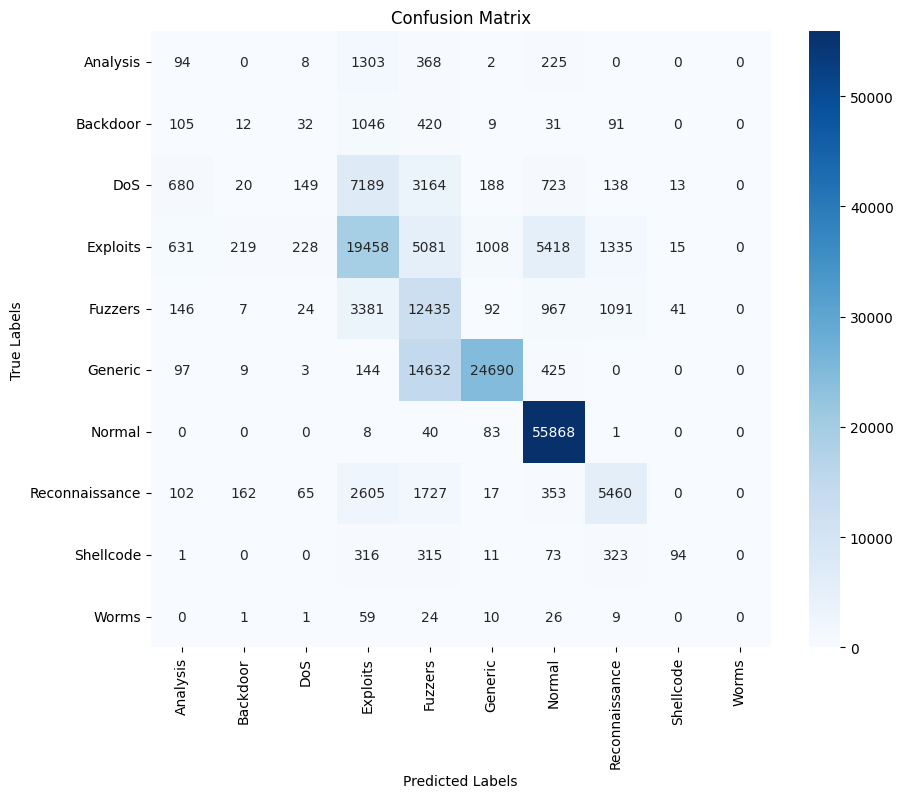

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary to map encoded labels to real class names
label_to_class_name = {i: class_names[i] for i in range(len(class_names))}

# Generate the confusion matrix
cm = confusion_matrix(y_test_int, y_pred_multiclass)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()